# Klasterovanje - 3. čas

**Peripheral Blood Mononuclear Cells (PBMC)** su tip ćelija koje se nalaze u ljudskoj krvi i igraju ključnu ulogu u imunološkom sistemu. To su ćelije koje imaju jednu okruglu jedrovu strukturu, pa su zbog toga poznate kao "mononuklearne ćelije." PBMC uključuju **limfocite** (kao što su T ćelije, B ćelije, i prirodne ćelije ubice – NK ćelije) i **monocite**. Zajedno, ovi tipovi ćelija pomažu telu da prepozna i odgovori na patogene, kao što su virusi i bakterije, i imaju ključnu ulogu u održavanju zdravlja kroz imunološku funkciju.

Na sajtu predmeta se mogu preuzeti PBMC podaci. U datasetu, svaki red predstavlja jednu ćeliju u kojoj su izmereni nivoi ekspresije gena koji su važni za funkciju te ćelije. Ekspresija gena, odnosno koliko je određeni gen "aktiviran" u ćeliji, meri se brojčano. Tako na primer, visoka ekspresija gena CD3D i CD3E ukazuje na prisustvo T ćelije, jer su ti geni karakteristični za T ćelije.

Ovaj dataset nam omogućava da analiziramo koji geni su aktivni u različitim tipovima ćelija imunog sistema. Na primer, možemo razumeti kako se B ćelije razlikuju od T ćelija na osnovu njihovih gena i pratiti kako imunološke ćelije reaguju u stanjima kao što su infekcije ili autoimuni poremećaji.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, silhouette_score, homogeneity_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv('../../pbmc_za_vezbu/D15_BS1_1.csv', header=None)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,row_desc,hg38_CD3D,hg38_CTSS,hg38_RPS26,hg38_IL32,hg38_FCER1A,hg38_CSTA,hg38_GZMB,hg38_CD74,hg38_RPS27,...,hg38_CD3E,hg38_KLRF1,hg38_LYZ,hg38_S100A9,hg38_CD79A,Group,Cell_type,Cell_subtype,Combination,Izbor_1
1,BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-...,0,0,3,0,0,0,0,7,7,...,0,0,0,0,4,BS1,BC,Bmemory,BS1 BC,1_Training
2,BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-...,0,3,3,0,0,0,0,6,7,...,0,0,0,0,4,BS1,BC,Bmemory,BS1 BC,1_Training
3,BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-...,3,0,3,4,0,0,0,5,7,...,3,0,0,0,2,BS1,BC,Bmemory,BS1 BC,1_Training
4,BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-...,0,3,0,0,0,0,0,7,7,...,0,0,0,0,4,BS1,BC,Bmemory,BS1 BC,2_Testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13179,BS1__TC__1-OK-T_cells_T8naive-860-NYC-BROADS1-...,3,3,5,4,0,0,0,0,7,...,4,0,0,0,0,BS1,TC,T8naive,BS1 TC,3_Validation
13180,BS1__TC__1-OK-T_cells_T8naive-860-NYC-BROADS1-...,3,0,5,4,0,0,0,3,7,...,4,0,0,3,3,BS1,TC,T8naive,BS1 TC,1_Training
13181,BS1__TC__1-OK-T_cells_T8naive-860-NYC-BROADS1-...,3,0,5,3,0,0,0,3,7,...,4,0,3,3,0,BS1,TC,T8naive,BS1 TC,2_Testing
13182,BS1__TC__1-OK-T_cells_T8naive-860-NYC-BROADS1-...,3,0,5,4,0,0,0,0,7,...,4,0,3,0,0,BS1,TC,T8naive,BS1 TC,1_Training


In [13]:
data.iloc[1,0]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB_5'

In [14]:
data.iloc[2,0]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB_13'

In [15]:
data.iloc[3,0]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB_19'

Ako sufiksi označavaju varijacije iste osnovne klase (npr., B ćelija_1, B ćelija_2), uklanjanjem sufiksa dobija se ujednačena oznaka klase (npr., samo B ćelija). Ovo pomaže pri grupisanju ćelija po istim osnovnim tipovima, umesto po podvarijantama. Ujednačeni nazivi bez sufiksa pojednostavljuju analizu i vizualizaciju jer se različite podvarijante posmatraju kao jedna kategorija, što može biti korisno u analizama koje nisu fokusirane na detalje između podtipova.

In [16]:
# Regularnim izrazom se pronalaze i uklanjaju sufiksi _1 _2, ...
klase = data.iloc[:, 0].apply(lambda x: re.sub(r'_\d+$', '', x))

In [27]:
klase[0]

'row_desc'

In [21]:
klase[1]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB'

In [22]:
klase[2]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB'

In [23]:
klase[10]

'BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB'

In [26]:
np.unique(klase)

array(['BS1__BC__1-OK-B_cells_Bmemory-580-BOS-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bmemory-580-NYC-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bmemory-860-BOS-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bmemory-860-NYC-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bnaive-580-BOS-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bnaive-580-NYC-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bnaive-860-BOS-BROADS1-CHECKED_VB',
       'BS1__BC__1-OK-B_cells_Bnaive-860-NYC-BROADS1-CHECKED_VB',
       'BS1__DC__1-OK-DC_cells_ALL-580-BOS-BROADS1-CHECKED_VB',
       'BS1__DC__1-OK-DC_cells_ALL-580-NYC-BROADS1-CHECKED_VB',
       'BS1__DC__1-OK-DC_cells_ALL-860-BOS-BROADS1-CHECKED_VB',
       'BS1__DC__1-OK-DC_cells_ALL-860-NYC-BROADS1-CHECKED_VB',
       'BS1__MC__1-OK-Monocytes_CD14+M-580-BOS-BROADS1-CHECKED_VB',
       'BS1__MC__1-OK-Monocytes_CD14+M-580-NYC-BROADS1-CHECKED_VB',
       'BS1__MC__1-OK-Monocytes_CD14+M-860-BOS-BROADS1-CHECKED_VB',
       '

B_cells_Bmemory - 1
B_cells_Bnaive - 1
DC_cells_ALL - 2
Monocytes_CD14+M - 3
Monocytes_CD16+M - 3
NK_cells_ALL - 4
T_cells_NonClassicalT -5
T_cells_T4eff.mem - 5
T_cells_T4naive - 5
T_cells_T8eff.mem - 5
T_cells_T4naive - 5
T_cells_aTreg - 5
T_cells_nonT - 5
T_cells_rTreg - 5
row_desc - 6

In [32]:
data.drop(columns=[0,16,17,18,19,20],axis=0,inplace=True)

In [33]:
data.drop(index=0,inplace=True)

In [34]:
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,0,0,3,0,0,0,0,7,7,0,0,0,0,0,4
2,0,3,3,0,0,0,0,6,7,0,0,0,0,0,4
3,3,0,3,4,0,0,0,5,7,0,3,0,0,0,2
4,0,3,0,0,0,0,0,7,7,0,0,0,0,0,4
5,0,3,4,0,3,0,0,7,7,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13179,3,3,5,4,0,0,0,0,7,0,4,0,0,0,0
13180,3,0,5,4,0,0,0,3,7,0,4,0,0,3,3
13181,3,0,5,3,0,0,0,3,7,0,4,0,3,3,0
13182,3,0,5,4,0,0,0,0,7,0,4,0,3,0,0


In [35]:
X_1_graph = kneighbors_graph(
    data, 
    n_neighbors=150, 
    mode='distance', 
    metric='cosine',
    n_jobs=-1
)

X_1_graph_map = kneighbors_graph(
    data, 
    n_neighbors=150, 
    mode='connectivity', 
    metric='cosine',
    n_jobs=-1
)

In [36]:
X_1_graph

<13183x13183 sparse matrix of type '<class 'numpy.float64'>'
	with 1977450 stored elements in Compressed Sparse Row format>

In [41]:
X_1_graph_arr = X_1_graph.toarray()

In [38]:
X_1_graph_map

<13183x13183 sparse matrix of type '<class 'numpy.float64'>'
	with 1977450 stored elements in Compressed Sparse Row format>

In [39]:
X_1_graph_map_arr = X_1_graph_map.toarray()

In [42]:
X_1_graph_full = X_1_graph_arr
X_1_graph_full = 1.0 / (1.0 + X_1_graph_arr)

In [43]:
X_1_graph_full[X_1_graph_map_arr == 0] = 0

In [45]:
sc = SpectralClustering(
    n_clusters=5, 
    affinity='precomputed', 
    n_components=2
)
sc.fit(X_1_graph_full)

C:\Users\KORISNIK\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


SpectralClustering(affinity='precomputed', n_clusters=5, n_components=2)

In [46]:
pca = PCA()
pca.fit(data)
X_pca = pca.transform(data)

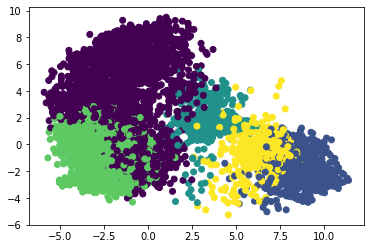

In [60]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sc.labels_)

In [61]:
silhouette_score(data, labels=sc.labels_, metric='cosine')

0.343547164713615

In [63]:
ac = AgglomerativeClustering(
    n_clusters=15, 
    affinity='cosine', 
    linkage='average'
)
fitted_model = ac.fit(data)

In [65]:
silhouette_score(data, labels=ac.labels_, metric='cosine')

0.36230795385089765

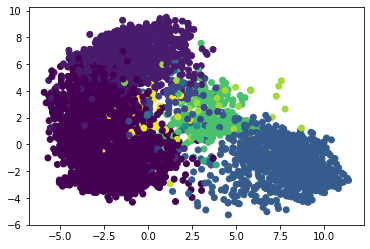

In [66]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ac.labels_)